# Train decoder

## Dataset loading

### Import libraries

In [11]:
from datasets import load_dataset
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import os

os.chdir("/home/ubuntu/")

### Load dataset

Load the dataset with hugging face and split between train and test.

In [12]:
ds = load_dataset('json', data_files='/home/ubuntu/data/intestinal_organoid_dataset/one_image_metadata.json')

test_dataset = ds["train"].filter(lambda example: example["split"] == "test")
del(ds)

Define the local folder where the dataset is located.

In [13]:
# Define dataset location folder
data_folder = "/home/ubuntu/data/intestinal_organoid_dataset/"

Define the processor (encoder) of SAM.

In [14]:
from transformers import SamProcessor

processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

Adapt the actual dataset for SAM.

In [15]:
from utils.sam_dataset import SAMDataset
sam_test_dataset = SAMDataset(dataset=test_dataset, processor=processor, data_folder=data_folder)
del(test_dataset)

In [16]:
item = sam_test_dataset[0]
print("Keys in item:", item.keys())  # Add this line to print the keys

Keys in item: dict_keys(['pixel_values', 'original_sizes', 'reshaped_input_sizes', 'input_boxes', 'ground_truth_mask', 'original_image'])


### Create PyTorch dataloader

In [17]:
from torch.utils.data import DataLoader

test_dataloader = DataLoader(sam_test_dataset, batch_size=3, shuffle=True)

In [18]:
batch = next(iter(test_dataloader))
for k,v in batch.items():
  print(k,v.shape)
del(k, v)

pixel_values torch.Size([3, 3, 1024, 1024])
original_sizes torch.Size([3, 2])
reshaped_input_sizes torch.Size([3, 2])
input_boxes torch.Size([3, 1, 4])
ground_truth_mask torch.Size([3, 450, 450])
original_image torch.Size([3, 450, 450, 3])


## Train SAM

### Load the model

Make sure we only compute gradients for the mask decoder

In [19]:
from transformers import SamModel 

model = SamModel.from_pretrained("facebook/sam-vit-base")

for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)
del(name)

See first mask prediction.

OutOfMemoryError: CUDA out of memory. Tried to allocate 2.25 GiB. GPU 0 has a total capacty of 14.58 GiB of which 616.56 MiB is free. Process 167833 has 8.49 GiB memory in use. Including non-PyTorch memory, this process has 5.49 GiB memory in use. Of the allocated memory 3.72 GiB is allocated by PyTorch, and 1.63 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

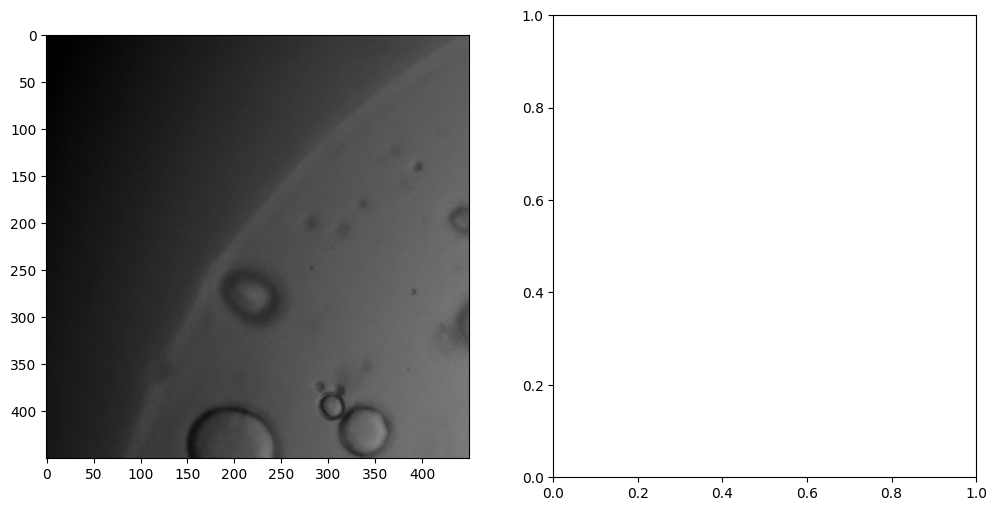

In [20]:
from utils.inference_sam import show_mask

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot Predicted Mask
axes[0].imshow(np.array(batch["original_image"][0]).squeeze())
first_masks = []
for batch in test_dataloader:
    # Compute mask
    outputs = model(pixel_values=batch["pixel_values"].to(device),
                    input_boxes=batch["input_boxes"].to(device),
                    multimask_output=False)
    # Post-process mask
    predicted_masks = outputs.pred_masks.to(device)
    predicted_masks = F.interpolate(predicted_masks.squeeze(1), (1024, 1024), 
                                    mode="bilinear", align_corners=False)
    predicted_masks = predicted_masks[..., :992, :1024]
    predicted_masks = F.interpolate(predicted_masks, (450, 450), 
                                    mode="bilinear", align_corners=False)
    # apply sigmoid
    mask_seg_prob = torch.sigmoid(predicted_masks)
    # convert soft mask to hard mask
    mask_seg_prob = mask_seg_prob.cpu().squeeze().detach().numpy()
    first_mask_seg = (mask_seg_prob > 0.5).astype(np.uint8)
    first_masks.append(first_mask_seg)
    for mask in first_mask_seg:
        show_mask(mask, axes[0])
axes[0].set_title("Predicted Mask")
axes[0].axis("off")

# Plot Ground Truth Mask
axes[1].imshow(np.array(batch["original_image"][0]).squeeze())
for batch in test_dataloader:
    ground_truth_masks = batch["ground_truth_mask"].float().squeeze().cpu()
    for mask in ground_truth_masks:
        show_mask(mask, axes[1])
axes[1].set_title("Ground Truth Mask")
axes[1].axis("off")

plt.show()

### Train the model

In [ ]:
from torch.optim import Adam
import monai
from utils.model_training import train_model


# Note: Hyperparameter tuning could improve performance here
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-4, weight_decay=0)
# Define geometrical loss
geom_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')
# Define number of epochs
num_epochs = 20
# Define parameters for topological loss
topo_param = {'lamda': 0.1, 
              'interp': 0, 
              'feat_d': 1, 
              'loss_q': 2, 
              'loss_r': False}

In [ ]:
# Run training function
train_model(model = model, optimizer = optimizer, geometric_loss = geom_loss, 
            dataloader = test_dataloader, num_epochs = num_epochs, device = device,
            topological_loss = True, topo_param = topo_param)

100%|██████████| 1/1 [00:22<00:00, 22.31s/it]


EPOCH: 1
Mean loss: 2.268930196762085


100%|██████████| 1/1 [00:22<00:00, 22.36s/it]


EPOCH: 2
Mean loss: 1.988517165184021


100%|██████████| 1/1 [00:22<00:00, 22.25s/it]


EPOCH: 3
Mean loss: 1.6955657005310059


100%|██████████| 1/1 [00:22<00:00, 22.21s/it]


EPOCH: 4
Mean loss: 1.7194076776504517


100%|██████████| 1/1 [00:22<00:00, 22.17s/it]


EPOCH: 5
Mean loss: 1.6559170484542847


100%|██████████| 1/1 [00:22<00:00, 22.26s/it]


EPOCH: 6
Mean loss: 1.6491001844406128


100%|██████████| 1/1 [00:22<00:00, 22.35s/it]


EPOCH: 7
Mean loss: 1.4334886074066162


100%|██████████| 1/1 [00:22<00:00, 22.42s/it]


EPOCH: 8
Mean loss: 1.2832937240600586


100%|██████████| 1/1 [00:22<00:00, 22.24s/it]


EPOCH: 9
Mean loss: 1.2053149938583374


100%|██████████| 1/1 [00:22<00:00, 22.19s/it]


EPOCH: 10
Mean loss: 1.151937484741211


100%|██████████| 1/1 [00:22<00:00, 22.37s/it]


EPOCH: 11
Mean loss: 1.4084547758102417


100%|██████████| 1/1 [00:22<00:00, 22.42s/it]


EPOCH: 12
Mean loss: 1.2019126415252686


100%|██████████| 1/1 [00:22<00:00, 22.26s/it]


EPOCH: 13
Mean loss: 1.0212634801864624


100%|██████████| 1/1 [00:22<00:00, 22.24s/it]


EPOCH: 14
Mean loss: 1.3435649871826172


100%|██████████| 1/1 [00:22<00:00, 22.36s/it]


EPOCH: 15
Mean loss: 1.0061843395233154


100%|██████████| 1/1 [00:22<00:00, 22.25s/it]


EPOCH: 16
Mean loss: 1.0483217239379883


100%|██████████| 1/1 [00:22<00:00, 22.26s/it]


EPOCH: 17
Mean loss: 1.0049413442611694


100%|██████████| 1/1 [00:22<00:00, 22.35s/it]


EPOCH: 18
Mean loss: 0.922850489616394


100%|██████████| 1/1 [00:22<00:00, 22.38s/it]


EPOCH: 19
Mean loss: 0.9519718885421753


100%|██████████| 1/1 [00:22<00:00, 22.21s/it]

EPOCH: 20
Mean loss: 0.8951731324195862


See now the results.

In [ ]:
from utils.inference_sam import show_mask

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Create a figure with two subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot Ground Truth Mask
axes[0].imshow(np.array(batch["original_image"][0]).squeeze())
for batch in test_dataloader:
    ground_truth_masks = batch["ground_truth_mask"].float().squeeze().cpu()
    for mask in ground_truth_masks:
        show_mask(mask, axes[0])
axes[0].set_title("Ground Truth Masks")
axes[0].axis("off")

# Plot Predicted Mask before training
axes[1].imshow(np.array(batch["original_image"][0]).squeeze())
for mask_batch in first_masks:
    for mask in mask_batch:
        show_mask(mask, axes[1])
axes[1].set_title("Predicted Masks without training")
axes[1].axis("off")

# Plot Predicted Mask after training
axes[2].imshow(np.array(batch["original_image"][0]).squeeze())
for batch in test_dataloader:
    # Compute mask
    outputs = model(pixel_values=batch["pixel_values"].to(device),
                    input_boxes=batch["input_boxes"].to(device),
                    multimask_output=False)
    # Post-process mask
    predicted_masks = outputs.pred_masks.to(device)
    predicted_masks = F.interpolate(predicted_masks.squeeze(1), (1024, 1024), 
                                    mode="bilinear", align_corners=False)
    predicted_masks = predicted_masks[..., :992, :1024]
    predicted_masks = F.interpolate(predicted_masks, (450, 450), 
                                    mode="bilinear", align_corners=False)
    # apply sigmoid
    mask_seg_prob = torch.sigmoid(predicted_masks)
    # convert soft mask to hard mask
    mask_seg_prob = mask_seg_prob.cpu().squeeze().detach().numpy()
    first_mask_seg = (mask_seg_prob > 0.5).astype(np.uint8)
    for mask in first_mask_seg:
        show_mask(mask, axes[2])
axes[2].set_title("Predicted Masks after training")
axes[2].axis("off")

plt.show()

ModuleNotFoundError: No module named 'utils'